# Imports

In [1]:

import cv2
import pickle
import matplotlib.pyplot as plt

from keras.initializers import glorot_uniform

from modules import lib
from modules import plots
from modules import models

# Parameters

In [2]:
seed = 42
params = {'x':224,                                
          'y':160,                                
          'batch_size': 8,                        
          'n_channels_mask': 1,                            
          'n_channels': 1,                        
          'shuffle': True,              
          'learningRate': 0.0001,                      
          'momentum': 0.98,                        
          'nEpoches': 20,                        
          }

dumps_path = "./dumps/"

lib.create_dump([params, seed], dumps_path + "params")


# Data loading & preprocessing

In [3]:

# LOAD DATA ==================================================================================
dataset  = "./Dataset" 
type_ds  = ['Images','Masks'] # sudivisione cartelle
X, y = lib.load_data(dataset, type_ds, params)

# SPLIT DATA ==================================================================================
ratio_test = 0.7
ratio_val = 0.9
X_train, X_test, X_val, y_train, y_test, y_val = lib.split_data(X, y, ratio_test, ratio_val, seed)
dataset_list = [X_train, X_test, X_val, y_train, y_test, y_val]

# Dumping splitted data
lib.create_dump(dataset_list, dumps_path + "splitted_data")

In [4]:
# DATA AUGMENTATION ==================================================================================
train_generator, val_generator = lib.data_augmentation(seed, dataset_list, params)

params["length_training"]   = len(X_train)
params['length_validation'] = len(X_val)
params["batch_size"] = 6


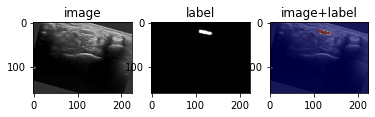

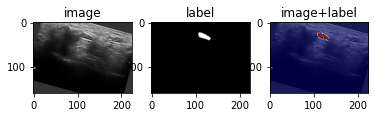

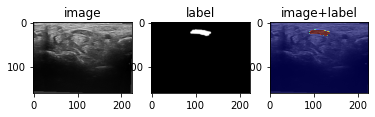

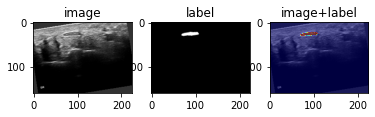

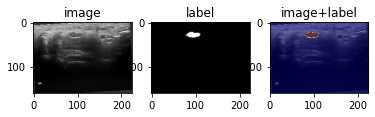

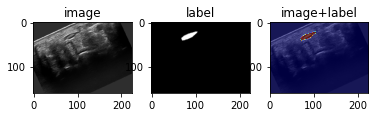

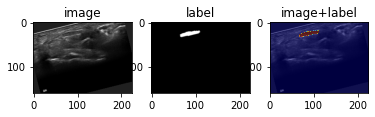

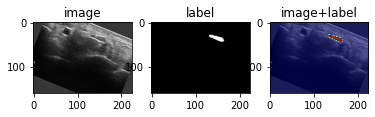

In [5]:
augmented_batch_plot = plots.plot_augmented_batch(train_generator)
plt.show()

# Model definition & training

Epoch 1/20
26/26 [==============================] - 24s 550ms/step - loss: 0.2524 - accuracy: 0.9877 - val_loss: 0.0566 - val_accuracy: 0.9903

Epoch 00001: val_loss improved from inf to 0.05657, saving model to ./results/weights/unet\
INFO:tensorflow:Assets written to: ./results/weights/unet\assets
Epoch 2/20
26/26 [==============================] - 11s 418ms/step - loss: 0.0437 - accuracy: 0.9880 - val_loss: 0.0399 - val_accuracy: 0.9897

Epoch 00002: val_loss improved from 0.05657 to 0.03986, saving model to ./results/weights/unet\
INFO:tensorflow:Assets written to: ./results/weights/unet\assets
Epoch 3/20
26/26 [==============================] - 11s 418ms/step - loss: 0.0341 - accuracy: 0.9879 - val_loss: 0.0359 - val_accuracy: 0.9902

Epoch 00003: val_loss improved from 0.03986 to 0.03586, saving model to ./results/weights/unet\
INFO:tensorflow:Assets written to: ./results/weights/unet\assets
Epoch 4/20
26/26 [==============================] - 11s 408ms/step - loss: 0.0301 - accur

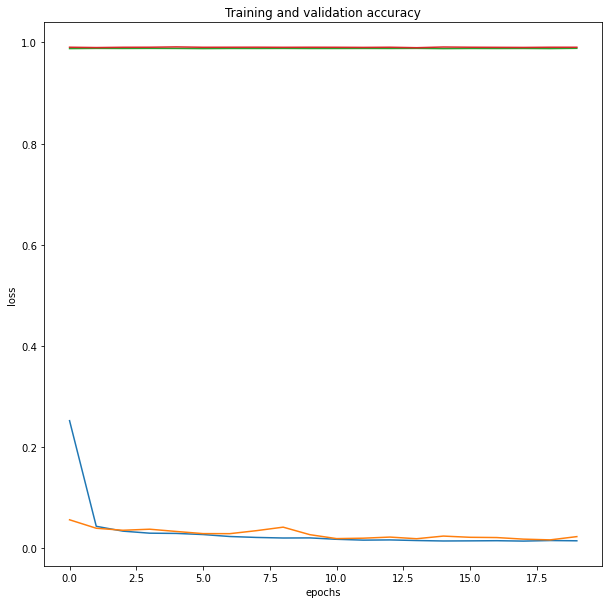

In [5]:

# DEFINE MODEL ====================================================================================
initializer = glorot_uniform()
input_size = (160,224,1)
model = models.unet(initializer, input_size)

# TRAIN MODEL ====================================================================================
root = './results/weights/unet/'

train_history, model = lib.train(root, params, model, train_generator, val_generator)

train_figure = plots.plot_train(train_history, params['nEpoches'])

plt.show()


# Testing results

testing accuracy: 0.985546875
testing dice: 0.6939226519337016


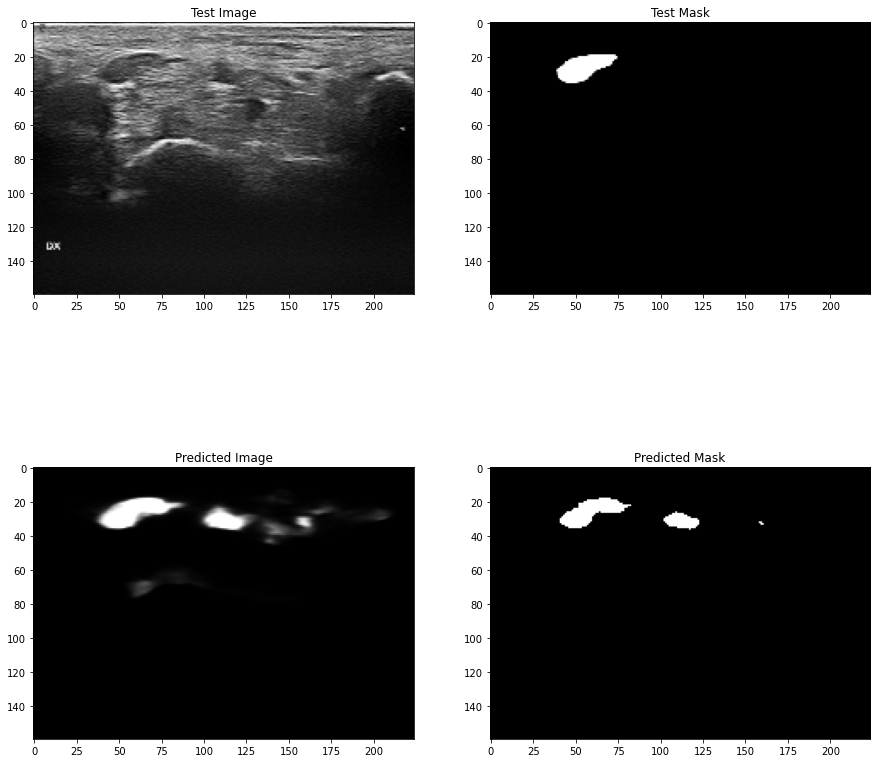

In [9]:
# Examine results

# Set the threshold for predictions
threshold = 0.45
# Select the image on which make 
image_index = 4
test_image = cv2.resize(X_test[image_index,:,:,0],(params["x"],params["y"]))
test_mask = cv2.resize(y_test[image_index,:,:,0],(params["x"],params["y"]))

test_results = lib.get_preditcions(test_image, test_mask, params, model, threshold)

print("testing accuracy:", lib.accuracy(test_mask, test_results["pred_mask"]))
print("testing dice:", lib.dice(test_mask, test_results["pred_mask"]))

results_figure = plots.plot_test_results(test_results)
plt.show()


# =====================================================================================================
